# 03. Pytorch Computer Vision

## 0. Computer Vision Libraries in pytorch

* `torchvision` - pytorch vision library
* `torchvision.datasets` - for loading datasets
* `torchvision.models` - for getting pretrained models
* `torchvision.transforms` - for image transforms or manipulating images
* `torch.utils.data.Dataset` - for base dataset class for pytorch
* `torch.utils.data.DataLoader` - creating a python iterable over a dataset

In [1]:
# import pytorch

import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib for visualizing data
import matplotlib.pyplot as plt

# check versions
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu124
0.19.0+cu124


## 1. Getting a dataset

use fashion mnist

In [2]:
# Setup Training data
train_data = datasets.FashionMNIST(
    root='data', # where to download data? 
    train=True, # do we want the training datasets
    download=True, # do we want to download
    transform=ToTensor(), # how do we want to transform the data
    target_transform=None # how do we want to transform the labels
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# see first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
# check the shape of our image
image.shape, label, train_data.classes[label]

(torch.Size([1, 28, 28]), 9, 'Ankle boot')

### 1.2 visualizing the data

image shape : torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

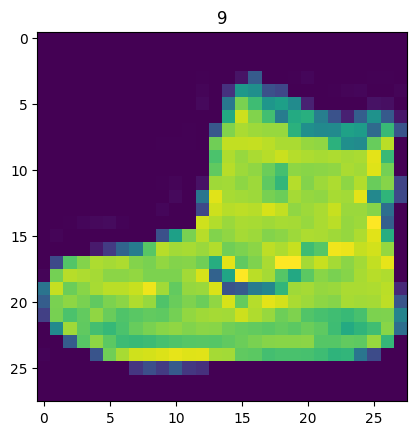

In [8]:
image, label = train_data[0]
print(f'image shape : {image.shape}')
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

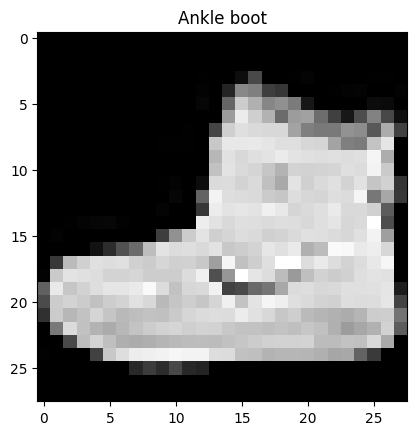

In [9]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(train_data.classes[label])

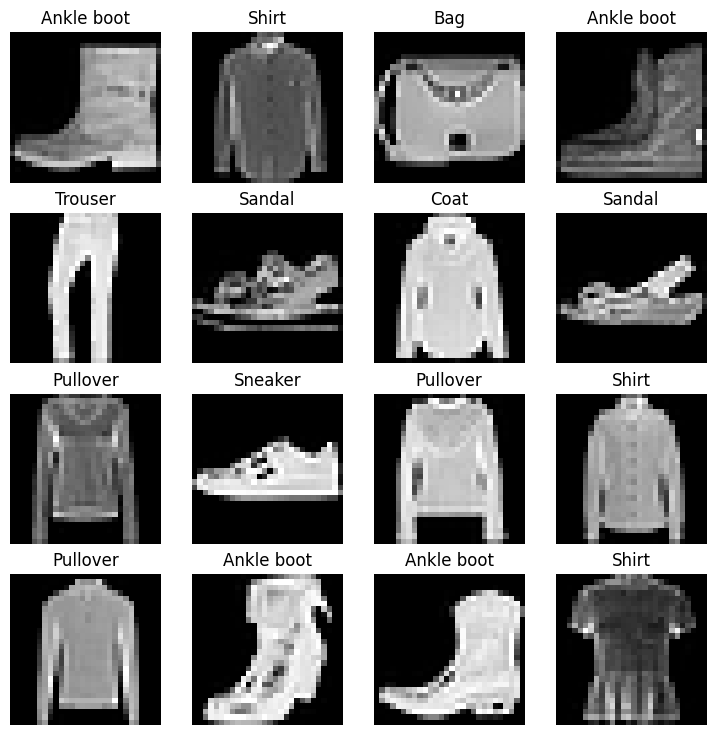

In [10]:
# random images, plotting more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_index = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

## 2. Prepare Data Loader

our data right now is in the form of pytorch Datasets.

DataLoader turns our dataset into a python iterable

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch.

In [11]:
from torch.utils.data import DataLoader

# setup batch size
BATCH_SIZE = 32

# turn datasets into python iterable
train_dataloder = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

train_dataloder, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e102c3fe80>,
 <torch.utils.data.dataloader.DataLoader at 0x1e10295b6a0>)

In [12]:
# check out yang udah di bikin
print(f'Dataloader: {train_dataloder, test_dataloader}')
print(f'Panjang Dataloader: {len(train_dataloder)} Batches of {BATCH_SIZE}')
print(f'Panjang Dataloader: {len(test_dataloader)} Batches of {BATCH_SIZE}')

Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x000001E102C3FE80>, <torch.utils.data.dataloader.DataLoader object at 0x000001E10295B6A0>)
Panjang Dataloader: 1875 Batches of 32
Panjang Dataloader: 313 Batches of 32


In [13]:
# cek apa yang di dalem training dataloader
train_freatures_batch, train_labels_batch = next(iter(train_dataloder))
train_freatures_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size = torch.Size([1, 28, 28])
Label = 8, Label Size = torch.Size([])


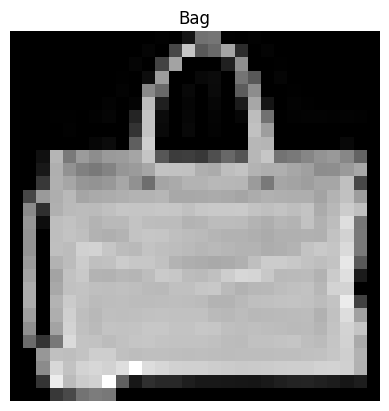

In [14]:
# show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_freatures_batch), size=[1]).item()
img, label = train_freatures_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(train_data.classes[label])
plt.axis(False)
print(f'Image Size = {img.shape}')
print(f'Label = {label}, Label Size = {label.shape}')

## 3. Create Model 0: Baseline Model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [15]:
# create a flatten layer
flatten_model = nn.Flatten()

# get single example
x = train_freatures_batch[0]
print(x.shape)

# flatten the sample
output = flatten_model(x)
print(output.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [16]:
# create Model 0

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

# setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(train_data.classes),
).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1,1,28,28])
model_0.eval()
with torch.inference_mode():
    dummy_y = model_0(dummy_x)
    print(dummy_y)
    print(dummy_y.shape)

tensor([[ 0.2826,  0.0491, -0.0742, -0.1099, -0.0071,  0.1045, -0.3287,  0.0522,
          0.3119, -0.3001]])
torch.Size([1, 10])


### 3.1 Setup Loss Function, Optimizer and evaluation metrics

* loss function - `nn.CrossentropyLoss()`
* optimizer - `torch.optim.SGD()`
* Evaluation metrics - classification problem, use accuracy evaluation metric `accuracy` 

In [19]:
# import helper functions
from helper_functions import accuracy_fn

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental, what we want to track is:
1. Model Performance (accuracy, loss, etc)
2. How fast it runs


In [21]:
from timeit import default_timer as timer 
def print_train_time(start: float,
                     end: float, 
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

### 3.3 Training Loop and training a model on batches on data

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate train loss per batch
3. Loop through testing batches, perform testing steps, calculate test loss per batch
4. Print out what's happening
5. Time it all

In [22]:
# import tqdm for progress bar
from tqdm.auto import tqdm

# device agnostic code
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# move model to gpu
# model_0 = model_0.to(device)


# set the seed and timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set the number of epochs
epochs = 3

# create a training loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}')
    train_loss = 0
    # add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloder):
        model_0.train()
        # move data to GPU
        # X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        if batch % 400 == 0:
            print(f'Looked at {batch * len(X)}/{len(train_dataloder.dataset)} samples')
            
    # divide total train loss by length of train dataloader
    train_loss /= len(train_dataloder)
    
    ### Testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # X_test, y_test = X_test.to(device), y_test.to(device)
            # 1. Forward pass
            test_pred = model_0(X_test)
            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y_test)
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
            
        # calculate the test loss  average per batch
        test_loss /= len(test_data)
        
        # calculate the test accuracy average per batch
        test_acc  /= len(test_dataloader)
        
    # print out whats happening
    print(f'\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}%')
    
# calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.6355 | Test Loss: 0.0166, Test Acc: 80.7907%
Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4999 | Test Loss: 0.0154, Test Acc: 82.6278%
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4741 | Test Loss: 0.0156, Test Acc: 82.8574%
Train time on cpu: 26.791 seconds


## 4. Make Predicstions and get Model 0 results

In [23]:
# setup device agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
torch.manual_seed(42)
def eval_mode(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device = device):
    """Returns a dictionary containing the results of model predicting data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # make predictions
            y_pred = model(X)
            
            # accumulate the loss and accuracy per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
        
        # scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {'Model_Name': model.__class__.__name__,
            'Model_loss': loss.item(),
            'Model_Acc': acc}
    
# calculate model 0 results on test dataset
model_0_results = eval_mode(model=model_0.to(device),
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model_Name': 'FashionMNISTModelV0',
 'Model_loss': 0.4988920986652374,
 'Model_Acc': 82.85742811501598}

## 5. Setup Device Agnostic Code

In [25]:
# setup device agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 6. Model 1: Build a better model using non linearity


we learned about the power of non linearity in the previous section. we will use it in this section.

In [26]:
# create a model with linear and non linear

from torch import nn

class FashionMNISTModelV1(nn.Module):
    def __init__(self, 
                 input_shape : int, 
                 hidden_units : int, 
                 out_shape : int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_shape),
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = FashionMNISTModelV1(
    input_shape=784,
    hidden_units=10,
    out_shape=len(train_data.classes)).to(device)

print("Device is :", next(model_1.parameters()).device)
print(model_1)

Device is : cuda:0
FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)


### 6.1 Loss, optimizer and evaluation metrics

In [28]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

### 6.2 Training loop

Functionizing a training loop and testing loop

In [29]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    '''
    Performs a training with model trying to learn on data_loader
    '''
    train_loss, train_acc = 0, 0
    
    # put model into training mode
    model.train()
    
    # add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):    
        # put data on target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss and acc (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y, 
                                 y_pred=y_pred.argmax(dim=1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
            
    # divide total train loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f'Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%')

In [30]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    '''Performs a testing loop step on model going over data_loader'''
    test_loss, test_acc = 0, 0
    # put the model in eval mode
    model.eval()
    
    # turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # send the data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, 
                                    y_pred=test_pred.argmax(dim=1))
            
        # adjust the metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        # print out what's happening
        print(f'\nTest Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%\n')    

In [31]:
torch.manual_seed(42)

# measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# set epochs
epochs = 3

# create optimization and evaluation step
for epoch in tqdm(range(epochs)):
    print(f'Epochs: {epoch}')
    train_step(model=model_1,
               data_loader=train_dataloder,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 0
Train Loss: 0.66768 | Train Acc: 75.88%

Test Loss: 0.50092 | Test Acc: 82.09%

Epochs: 1
Train Loss: 0.48344 | Train Acc: 82.77%

Test Loss: 0.48896 | Test Acc: 82.69%

Epochs: 2
Train Loss: 0.44955 | Train Acc: 83.87%

Test Loss: 0.48580 | Test Acc: 82.89%

Train time on cuda: 38.277 seconds


In [32]:
# get model_1 results in dictionary format
model_1_results = eval_mode(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)

model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model_Name': 'FashionMNISTModelV1',
 'Model_loss': 0.4858045279979706,
 'Model_Acc': 82.8873801916933}

## 7. Model 2: Building a Convolutional Neural Network

CNN is known as ConvNet

CNN are the best to find patterns in visual data

In [33]:
# create a convolutional neural network

class FashionMNISTModelV2(nn.Module):
    '''Model Architecture that replicates the tinyVGG, a model from CNN explainer website'''
    def __init__(self,
                 input_shape : int,
                 hidden_units : int,
                 output_shape : int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f'output of conv_block_1 shape: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'output of conv_block_2 shape: {x.shape}')
        x = self.classifier(x)
        return x

Note: you can use print shape in the forward method to find out the shape of the image before going to classifier block to be flatten to test this you can use a random tensor that is in the same shape as your image


In [34]:
image.shape

torch.Size([1, 28, 28])

In [35]:
# initiate model 2
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=16,
                              output_shape=len(train_data.classes)).to(device)

print(model_2)
print(next(model_2.parameters()).device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)
cuda:0


In [36]:
# example of random tensor test
random_tensor_model_2 = torch.randn(size=(1,28,28))
random_tensor_model_2.shape

torch.Size([1, 28, 28])

In [37]:
model_2.eval()
with torch.inference_mode():
    print(model_2(random_tensor_model_2.unsqueeze(dim=0).to(device)))

tensor([[ 0.0339, -0.0137, -0.0158,  0.0002,  0.0278,  0.0205, -0.0034,  0.0092,
         -0.0620, -0.0036]], device='cuda:0')


### 7.1 Stepping through `nn.Conv2D`

In [38]:
torch.manual_seed(42)

# create a random image
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'Test Image :\n {test_image}')

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test Image :
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-

In [39]:
test_image.shape

torch.Size([3, 64, 64])

In [40]:
torch.manual_seed(42)

# Create a sinlge conv2d layer

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer 
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 7.2 Stepping Through MaxPooling2d

In [41]:
test_image

tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978,  1.0261,  1.1465,  ...,  1.2134,  0.9354, -0.0780],
         [-1.4647, -1.9571,  0.1017,  ..., -1

In [42]:
# print out original image shape without unsqueezed dimension
print(f'Test Image original shape {test_image.shape}')


# create a sample maxpooling2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass data through the conv_layer
test_image_through_conv = conv_layer(test_image)
print(f'shape after going through conv_layer(): {test_image_through_conv.shape}')

# pass data through the maxpool_layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f'shape after going conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}')

Test Image original shape torch.Size([3, 64, 64])
shape after going through conv_layer(): torch.Size([10, 62, 62])
shape after going conv_layer() and max_pool_layer(): torch.Size([10, 31, 31])


### 7.3 Setup a loss function and optimizer for model_2

In [43]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.4 Training and testing model_2 using our training and test step

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# measure time
from timeit import default_timer as timer

train_time_start_on_model_2 = timer()

# number of epochs
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}')
    train_step(model=model_2,
               data_loader=train_dataloder,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_on_model_2 = timer()

total_train_time_model_2 = print_train_time(start=train_time_start_on_model_2,
                                            end=train_time_end_on_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.55544 | Train Acc: 79.74%

Test Loss: 0.36112 | Test Acc: 87.04%

Epoch: 1
Train Loss: 0.32847 | Train Acc: 88.13%

Test Loss: 0.33250 | Test Acc: 88.44%

Epoch: 2
Train Loss: 0.28757 | Train Acc: 89.67%

Test Loss: 0.28337 | Test Acc: 89.86%

Train time on cuda: 43.012 seconds


In [45]:
# get model_2 results
model_2_results = eval_mode(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

  0%|          | 0/313 [00:00<?, ?it/s]

## 8. Compare model results and training time

In [46]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,Model_Name,Model_loss,Model_Acc
0,FashionMNISTModelV0,0.498892,82.857428
1,FashionMNISTModelV1,0.485805,82.887380
2,FashionMNISTModelV2,0.283373,89.856230


In [47]:
# add training time to results comparison
compare_results['training time'] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,Model_Name,Model_loss,Model_Acc,training time
0,FashionMNISTModelV0,0.498892,82.857428,26.791357
1,FashionMNISTModelV1,0.485805,82.887380,38.277117
2,FashionMNISTModelV2,0.283373,89.856230,43.011957


Text(0, 0.5, 'model')

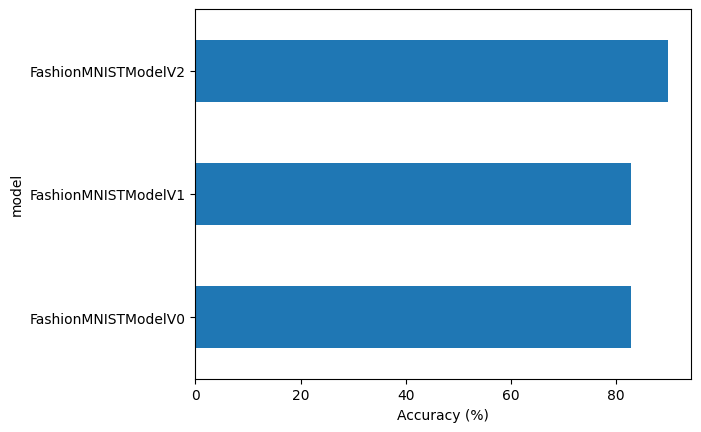

In [48]:
# visualize our model results
compare_results.set_index('Model_Name')['Model_Acc'].plot(kind='barh')
plt.xlabel('Accuracy (%)')
plt.ylabel('model')

## 9. Make and evaluate random predictions with best model

In [49]:
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = device):
    pred_probs = []
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # forward pass (model outputs raw logits)
            pred_logit = model(sample)
            # get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            # get pred prob off the gpu for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # stack the pred probs to turn list into a tensor
    return torch.stack(pred_probs)

In [50]:
import random

# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
# view the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Trouser')

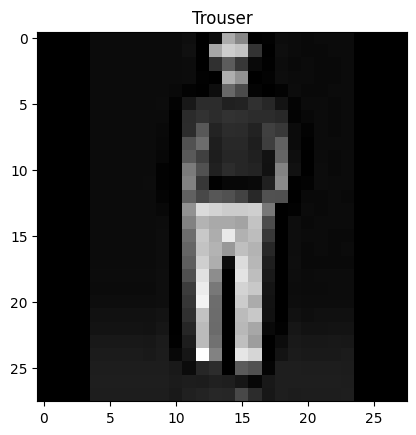

In [51]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(test_data.classes[test_labels[0]])

In [52]:
# make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# view the first two prediction probabilities
pred_probs[:2]

tensor([[1.0695e-01, 7.2170e-01, 1.7409e-02, 2.6009e-02, 4.0384e-02, 3.1835e-03,
         4.9093e-02, 3.0450e-03, 3.1642e-02, 5.8370e-04],
        [9.9938e-01, 1.5554e-06, 3.3951e-04, 6.4823e-06, 2.9978e-07, 3.3121e-06,
         2.3893e-04, 5.0379e-07, 2.4810e-05, 1.3653e-07]])

In [53]:
# convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)
print("\n",test_labels)

tensor([1, 0, 8, 6, 0, 3, 5, 3, 5])

 [1, 0, 8, 6, 0, 3, 5, 3, 5]


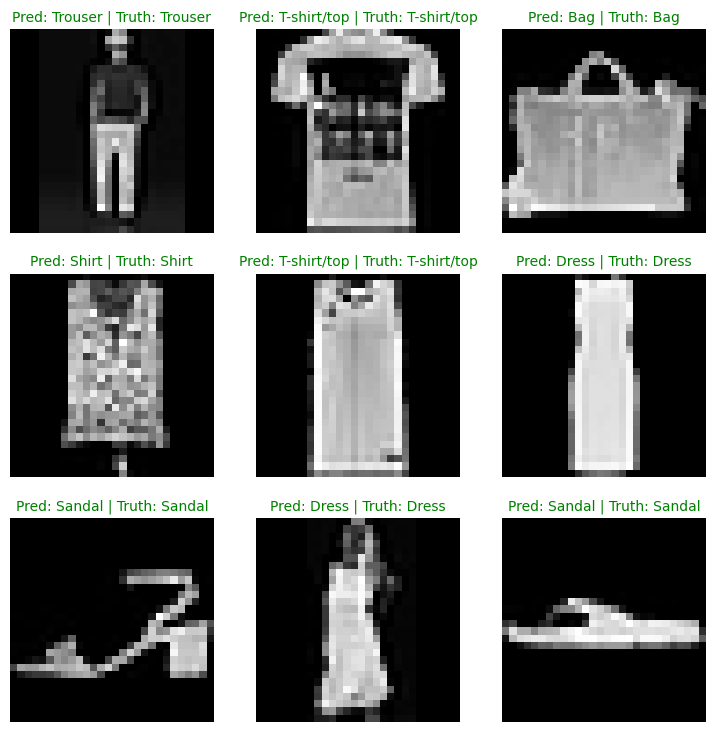

In [54]:
# plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # create a subplot
    plt.subplot(nrows, ncols, i+1)
    
    # plot the target image
    plt.imshow(sample.squeeze(), cmap='gray')
    
    # find the prediction label in text forms
    pred_label= test_data.classes[pred_classes[i]]
    
    # get the truth label
    truth_label = test_data.classes[test_labels[i]]
    
    # create a title for the plot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'
    
    # check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
        
    plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

1. make predictions with our trained model on test dataset
2. make a confusion matrix with torchmetrics
3. plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix()

In [55]:
import mlxtend
mlxtend.__version__

'0.23.1'

In [56]:
# make predictions with trained models
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 0])

In [57]:
len(y_pred_tensor)

10000

In [58]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

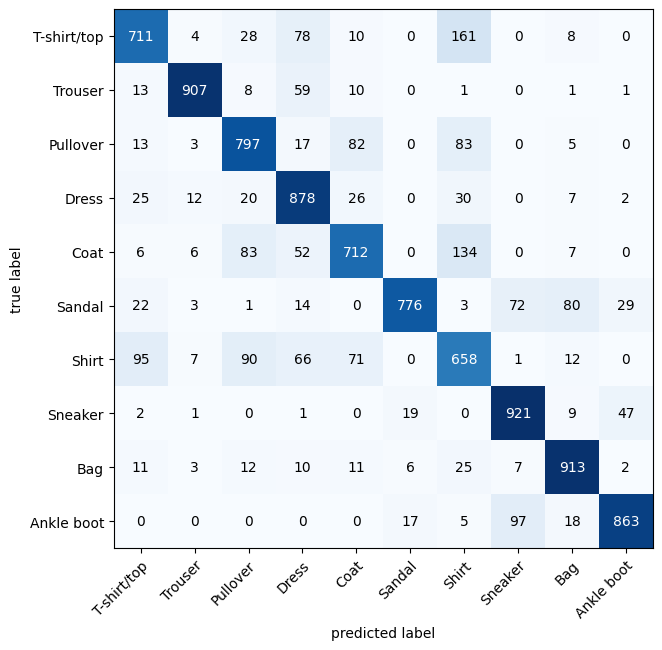

In [59]:
# 2. setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7))